## Exploratory comparison of StJude soft-tissue, pediatric cancer data and EPICYCLE data

The normalized and pre-processed gene expression data from StJude and EPICYCLE are visualized and compared.


In [ ]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import os

#meta = pd.read_csv("SAMPLE_INFO.txt.gz", sep="\t").set_index("sample_name")

In [ ]:
ad = sc.read_h5ad('../data/st_jude_and_epicycle_adata.h5ad')

In [4]:
sc.pp.pca(ad)

In [5]:
sc.pp.neighbors(ad)

/home/marjens/miniconda3/envs/jup/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


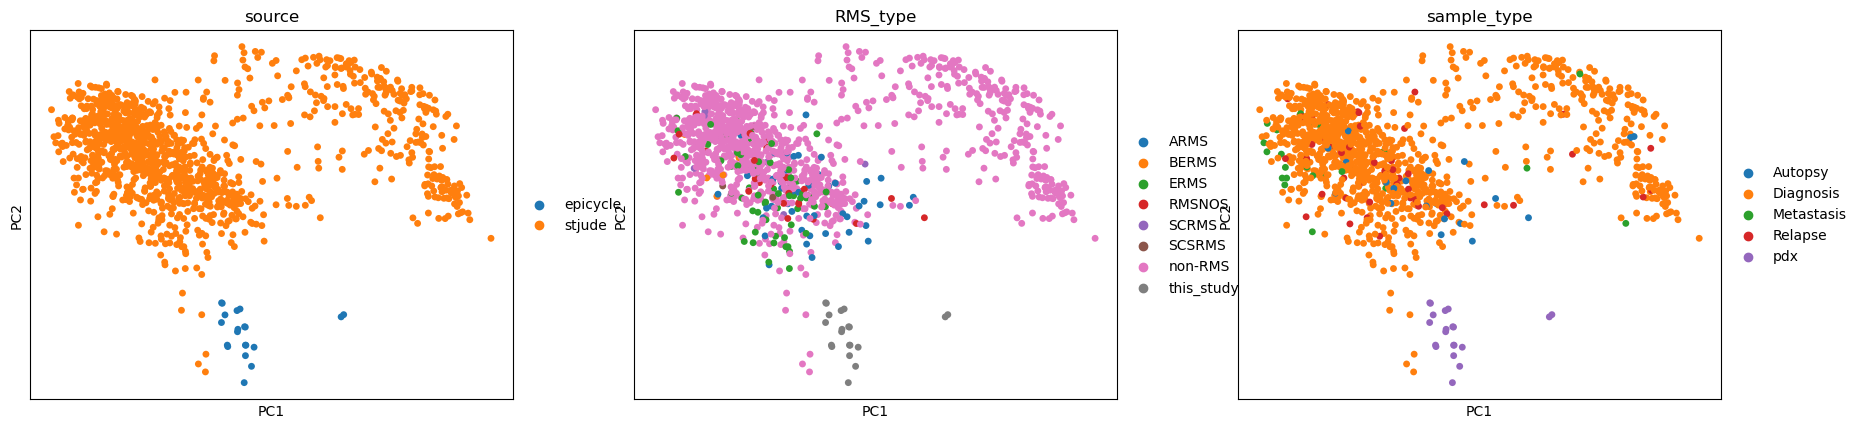

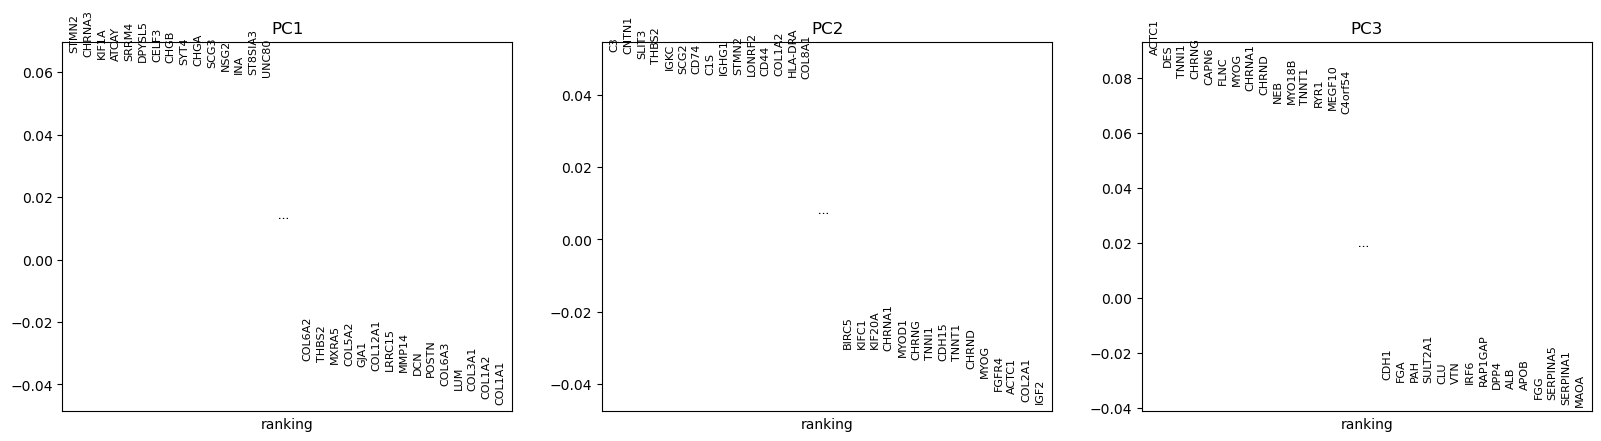

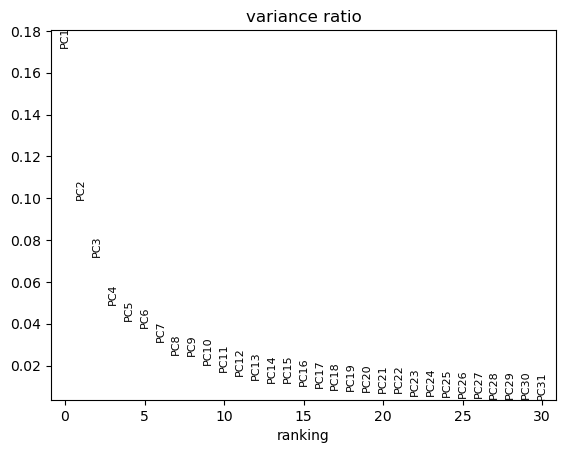

In [6]:
sc.pl.pca_overview(ad, color=['source', 'RMS_type', 'sample_type',])

In [7]:
sc.tl.umap(ad)

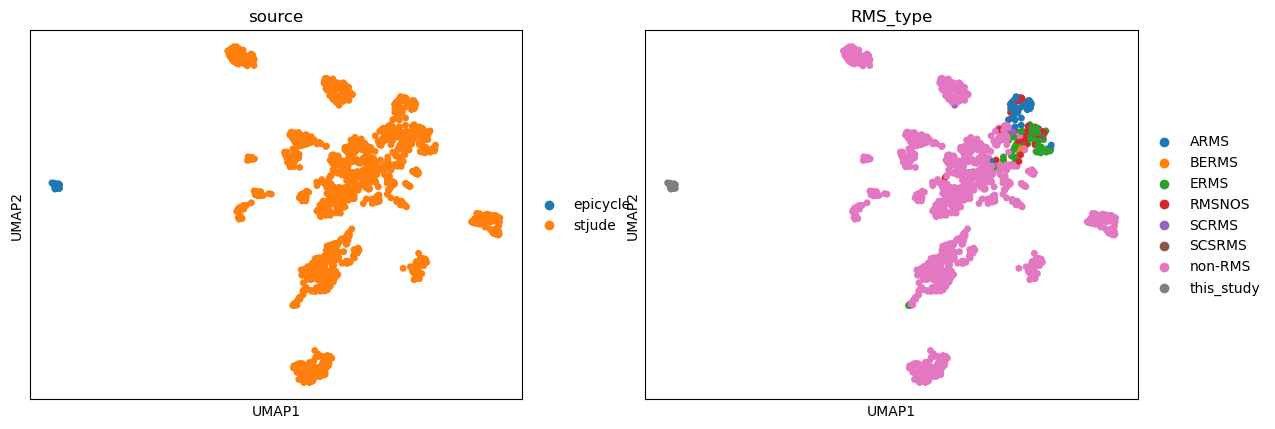

In [8]:
sc.pl.umap(ad, color=['source', 'RMS_type'])

### Conclusions

There is a marked difference between the presentation of our samples and the StJude samples. This should not come as a surprise, as there were different protocols and methods involved at every step (we have PDX material for example). This notwithstanding, we can still ask which StJude samples are the most similar to the EPICYCLE samples.
For this, we will compute pairwise correlations between each sample from EPICYCLE and each sample from the StJude soft tissue catalog.

In [19]:
# optional: center each gene on mean=0 expression and scale to unit variance
sc.pp.scale(ad)

In [20]:
DF = ad.to_df()

In [21]:
ad_sj = ad[ad.obs['source'] == 'stjude']
ad_ec = ad[ad.obs['source'] == 'epicycle']

In [30]:
# compute Pearson correlation between each EPICYCLE sample/replicate and each sample in the St Jude catalog
# correlation is computed not over all genes, but the 3k most highly variable genes (see stjude_download_and_preprocess.ipynb)
import numpy as np
from scipy.stats import pearsonr

corr = {
    'query': [],
    'sample_name': [],
    'corr': [],
}
for query in ad_ec.obs_names:
    print(query)
    for target in ad_sj.obs_names:
        corr['corr'].append(pearsonr(DF.loc[query, ad.var.highly_variable].values, DF.loc[target, ad.var.highly_variable].values).statistic)
        corr['query'].append(query)
        corr['sample_name'].append(target)
    

IC35.r1
IC35.r2
X16.r1
X16.r2
IC104.r1
IC104.r2
BE14.r1
BE14.r2
R410.r1
R410.r2
IC29.r1
IC29.r2
BE13.r1
BE13.r2
X1.r1
X1.r2
ZH3.r1
ZH3.r2
Be10.r1
Be10.r2


In [31]:
C = pd.DataFrame(corr)

In [32]:
C['RMS_type'] = ad_sj.obs.loc[C['sample_name'], 'RMS_type'].to_list()
# C['RMS_type'] = C['sample_name'].apply(lambda x : )

In [33]:
C.to_csv("../data/epicycle_vs_stjude_correlations.tsv.gz", sep='\t')

Text(0.5, 28.999999999999986, 'St. Jude RMS data')

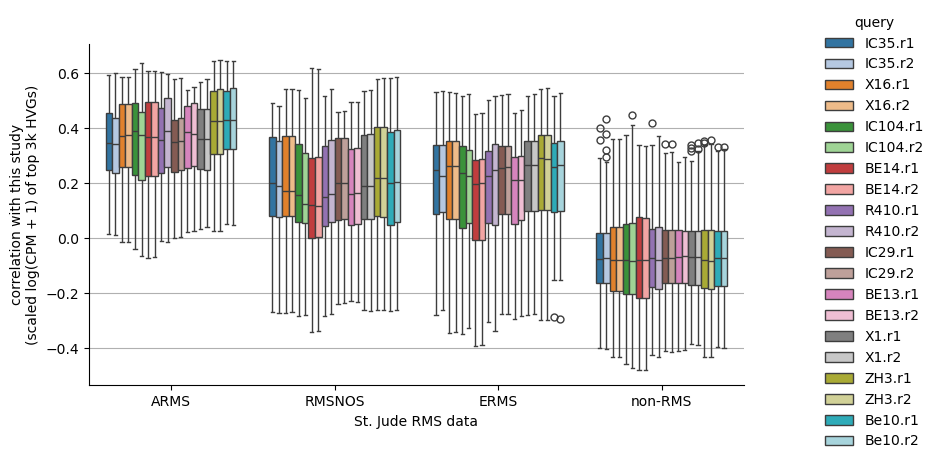

In [34]:
g = sns.catplot(data=C.sort_values('corr', ascending=False), x='RMS_type', y='corr', hue='query', hue_order=ad_ec.obs_names.to_list(), order=['ARMS', 'RMSNOS', 'ERMS', 'non-RMS'], dodge=True, kind='box', palette='tab20')
g.fig.set_size_inches(10, 4)
g.ax.grid(visible='both', axis='y')
g.ax.set_ylabel("correlation with this study\n(scaled log(CPM + 1) of top 3k HVGs)")
g.ax.set_xlabel("St. Jude RMS data")

In [35]:
g.savefig('../plots/epicycle_stjude_RMS_correlations.pdf')
g.savefig('../plots/epicycle_stjude_RMS_correlations.png', dpi=300)

### Within-catalog correlations

To gauge if the observed correlations are high or low, let's compare them to within-catalog correlations. Comparing EPICYCLE to EPICYCLE and stjude ARMS to stjude ARMS.

In [36]:
sub = ad[ad.obs['RMS_type'] == 'ARMS', ad.var.highly_variable]

In [37]:
ctrl = sub.to_df().T.corr()

In [38]:
keep = np.triu(np.ones(ctrl.shape), 1).astype('bool').reshape(ctrl.size)
ctrl = ctrl.stack()[keep]

In [39]:
ctrl = ctrl.reset_index()

In [40]:
ctrl['label'] = "ARMS_vs_ARMS"
ctrl['label'] = pd.Categorical(ctrl['label'])

In [41]:
ctrl.columns

Index(['level_0', 'level_1', 0, 'label'], dtype='object')

In [42]:
ctrl

,level_0,level_1,0,label
0,SJRHB030480_D1,SJRHB030445_D1,0.686883,ARMS_vs_ARMS
1,SJRHB030480_D1,SJRHB030476_D1,0.673612,ARMS_vs_ARMS
2,SJRHB030480_D1,SJRHB030550_D1,0.710165,ARMS_vs_ARMS
3,SJRHB030480_D1,SJRHB030495_D1,0.635808,ARMS_vs_ARMS
4,SJRHB030480_D1,SJRHB030421_D1,0.521830,ARMS_vs_ARMS
...,...,...,...,...
1171,SJRHB030550_R1,SJRHB033907_D1,0.632370,ARMS_vs_ARMS
1172,SJRHB030550_R1,SJRHB034210_D1,0.681066,ARMS_vs_ARMS
1173,SJST033686_D1,SJRHB033907_D1,0.655433,ARMS_vs_ARMS
1174,SJST033686_D1,SJRHB034210_D1,0.504900,ARMS_vs_ARMS


In [43]:
ctrl['query'] = 'St. Jude vs St. Jude ARMS'
ctrl['sample_name'] = ctrl['level_1']
ctrl['corr'] = ctrl[0]
ctrl['RMS_type'] = 'ARMS_vs_ARMS_ctrl'

In [44]:
sub_ec = ad[ad.obs['source'] == 'epicycle', ad.var.highly_variable]

In [45]:
ctrl_ec = sub_ec.to_df().T.corr()

In [46]:
keep = np.triu(np.ones(ctrl_ec.shape), 1).astype('bool').reshape(ctrl_ec.size)
ctrl_ec = ctrl_ec.stack()[keep]

In [47]:
ctrl_ec = ctrl_ec.reset_index()

In [48]:
ctrl_ec['label'] = "epicycle_vs_epicycle"
ctrl_ec['label'] = pd.Categorical(ctrl_ec['label'])

In [49]:
ctrl_ec['query'] = 'epicycle vs epicycle ARMS'
ctrl_ec['sample_name'] = ctrl_ec['level_1']
ctrl_ec['corr'] = ctrl_ec[0]
ctrl_ec['RMS_type'] = ctrl_ec['label']

<Axes: xlabel='query', ylabel='corr'>

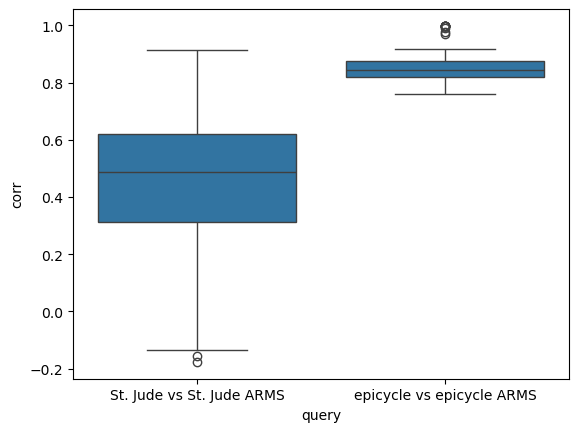

In [61]:
sns.boxplot(data=pd.concat([ctrl, ctrl_ec], ignore_index=True, axis=0), x='query', y='corr')

## Conclusions

There is substantial variation between ARMS samples in the StJude catalog, which is to be expected given that samples of different types and different protocols are grouped together here. In comparison, the variability among the EPICYCLE samples (all PDX, sequenced in parallel) is much lower.
Finally, comparison between EPICYCLE and StJude samples strongly supports that our PDX systems transcriptionally resemble the Alveolar RMS samples more closely than any other soft-tissue tumor. The degree of similarity is lower, but overall comparable to, the degree of similarity between different ARMS picked from the StJude catalog.

In [50]:
pd.concat([ctrl, ctrl_ec], ignore_index=True, axis=0)[['RMS_type', 'corr']].sort_values('corr', ascending=False)

,RMS_type,corr
1351,epicycle_vs_epicycle,0.997953
1275,epicycle_vs_epicycle,0.997870
1360,epicycle_vs_epicycle,0.997767
1213,epicycle_vs_epicycle,0.997551
1321,epicycle_vs_epicycle,0.997453
...,...,...
456,ARMS_vs_ARMS_ctrl,-0.133632
781,ARMS_vs_ARMS_ctrl,-0.134223
1052,ARMS_vs_ARMS_ctrl,-0.135257
1049,ARMS_vs_ARMS_ctrl,-0.155266


## What are the differences between EPICYCLE and StJude RMS data?

In [51]:
ad.obs

,sample_type,RMS_type,tissue,source
SJACT030424_D1,Diagnosis,non-RMS,ST,stjude
SJACT030437_D1,Diagnosis,non-RMS,ST,stjude
SJACT030487_D1,Diagnosis,non-RMS,ST,stjude
SJACT030812_D1,Diagnosis,non-RMS,ST,stjude
SJDSRCT030722_D1,Diagnosis,non-RMS,ST,stjude
...,...,...,...,...
X1.r2,pdx,this_study,ST,epicycle
ZH3.r1,pdx,this_study,ST,epicycle
ZH3.r2,pdx,this_study,ST,epicycle
Be10.r1,pdx,this_study,ST,epicycle


In [52]:
rms = ad[ad.obs['RMS_type'].isin(['this_study', 'ARMS'])]

In [53]:
rms

View of AnnData object with n_obs × n_vars = 69 × 34955
    obs: 'sample_type', 'RMS_type', 'tissue', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'source_colors', 'RMS_type_colors', 'sample_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'normed', 'raw_counts'
    obsp: 'distances', 'connectivities'

In [54]:
rms.X = rms.layers['log1p'].copy()

In [ ]:
# we redo this step bc we are now restricted to RMS samples only
sc.pp.highly_variable_genes(rms, flavor='cell_ranger', n_top_genes=3000)

/home/marjens/miniconda3/envs/jup/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


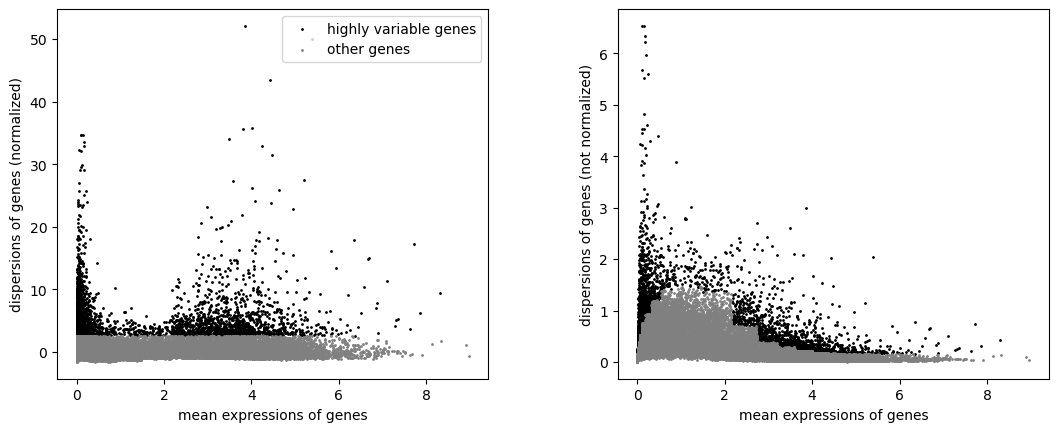

In [56]:
sc.pl.highly_variable_genes(rms)

In [57]:
sc.pp.neighbors(rms)

In [58]:
sc.pp.pca(rms)

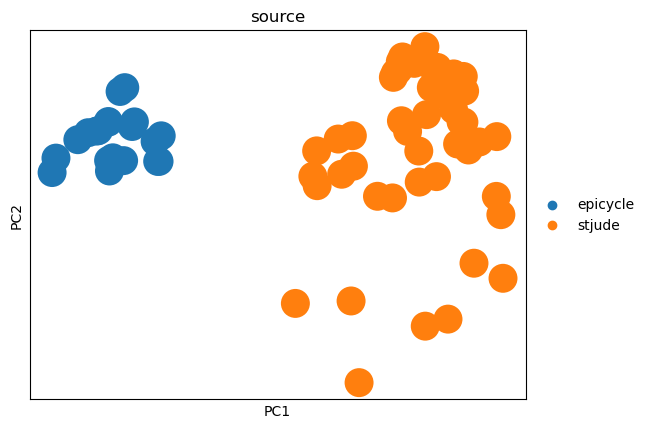

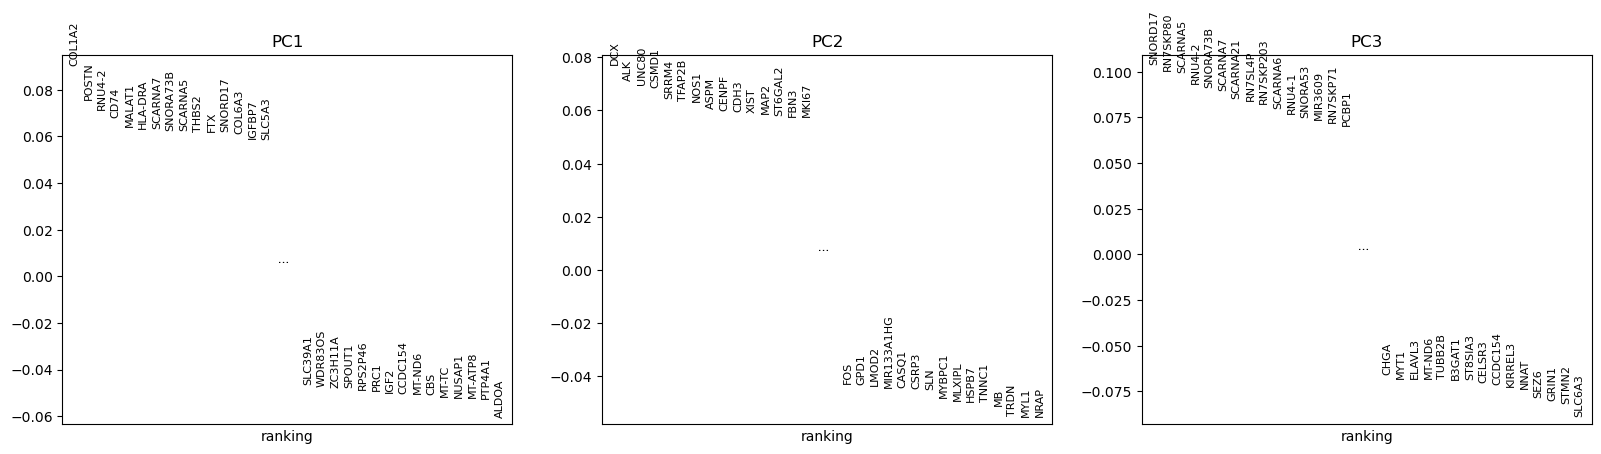

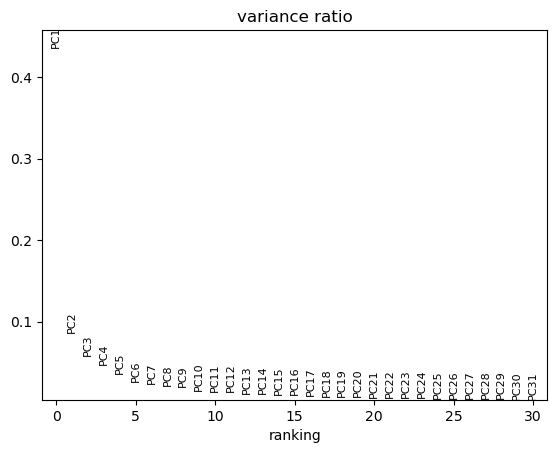

In [59]:
sc.pl.pca_overview(rms, color='source')

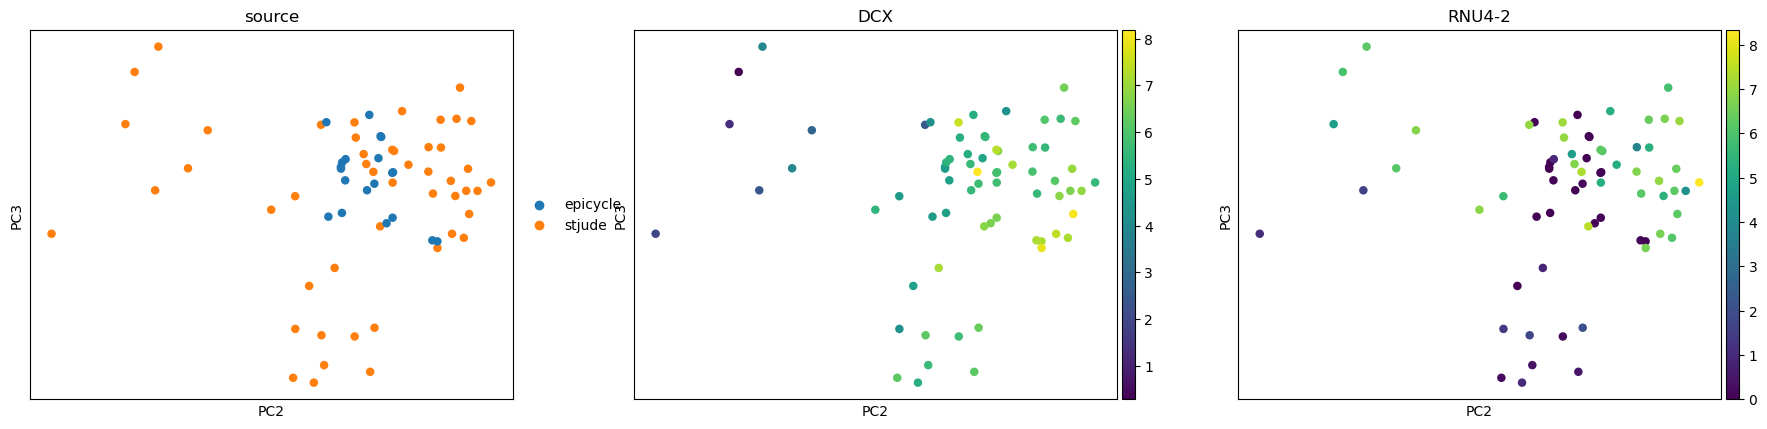

In [ ]:
sc.pl.pca(rms, color=['source', 'DCX', 'RNU4-2'], components="2,3", size=150)

Interesting! We find that PC1 separates EPICYCLE PDX models from StJude ARMS samples. This PC is driven by many genes that are either related to extra-cellular matrix (COL1A1, COL6A3, POSTN) or Antigen-presenting cells (HLA-DRA, CD74), which are apparently (and perhaps not surprisingly) much more highly expressed in patient-derived StJude samples, than in our PDXs. Along PC2, epicycle and StJude can not be separated. It appears to be driven by genes that vary along the degree of RMS differentiation. So, roughly, PC1 -> tumor microenevironment which differs between PDX and human, PC2 -> degree of differentiation.
PC3 is interesting as well, with markers of neural differentiation (CHGA, KIRREL3, ELAVL3) some of which are also observed in Neuroblastoma, but also a lot of non-coding RNAs, presumably required for RNA processing. RNU4-2 is a particularly strange one, noted for high expression specificially during brain development and with variants linked to disease: https://www.nature.com/articles/s41586-024-07773-7 

Of note: RNU is a non-polyadenylated, non-coding RNA which can not even be quantified by normal (poly-dT primed) mRNA-seq. So our samples have zero expression, whereas StJude samples appear to have used a total RNA-seq approach.

